## 💡 Project: **"VIP Complaint Prediction & Root Cause AI"**

### 📌 Background
VIP & Enterprise customers are **high value** — large contracts, significant revenue contribution, and operator reputation at stake.  
Currently, complaint handling is **reactive** → team only acts after a complaint is received.  
Problem: **delayed response**. Impact: contracts may incur penalties, customer trust decreases.

🔑 Solution: **AI Early Warning System** → predict potential complaints **before** customers raise them.

### 🎯 Objectives
1. **Complaint Prediction** → detect sites/clusters at risk of VIP complaints within the next 24 hours.  
2. **Root Cause Identification** → automate diagnosis based on KPI patterns (e.g., high PRB → slow internet).  
3. **Prioritization Alert** → send early warning notifications to the Network Engineer team.

### 🔑 Inputs (X – Features)
* **Radio KPIs**: Availability, RSRP, RSRQ, SINR, PRB DL/UL, Max/Active users, UL interference, HO success rate, CSSR.  
* **Core & Transport KPIs**: Packet loss, latency, CPRI/VSWR alarms.  
* **Service-Specific KPIs**: WhatsApp success ratio, VoLTE drop rate, SMS success ratio, Gaming latency.  
* **Events/External**: Maintenance schedules, concerts, national events, weather conditions.

### 🎯 Outputs (y – Target)
**Level 1 – Complaint Prediction (Binary)**  
Will the site/cluster likely generate a complaint in the next 24 hours? (Yes / No)

**Level 2 – Complaint Category (Multiclass)**  
Predicted complaint types:
- Internet Lag  
- Coverage / Signal Issues  
- WhatsApp Call Issues  
- Voice Call Issues  
- SMS Issues  
- Gaming Lag

**Level 3 – Root Cause Recommendation**  
Map prediction results to potential root causes:
- High PRB → capacity overload  
- Low RSRP → weak coverage  
- High UL interference → poor quality  
- Transport packet loss → core/transport problem

### 🚀 Value Proposition
- ✅ Shift from **Reactive → Proactive** VIP complaint handling.  
- ✅ **Improve SLA & customer experience** → prevent complaints before escalation.  
- ✅ Scalable to **all customer complaints**, not just VIP.  

### 🔗 Try the Demo
[Streamlit App](https://vip-complaint-prediction.streamlit.app/)


In [1]:
# 🛠 Install Required Libraries
# Lazypredict → quick baseline models for ML
# CatBoost → gradient boosting library (good for categorical + tabular data)
# Streamlit → web app framework for interactive dashboards

!pip install -q lazypredict
!pip install -q catboost
!pip install -q streamlit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.0/314.0 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.2/86.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 705.9/705.9 kB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/

In [2]:
# Import Libraries

# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import folium  # map visualization

# Geospatial & datetime utilities
from sklearn.metrics.pairwise import haversine_distances  # compute nearest site by lat/lon
from datetime import timedelta                           # select tickets within last 24 hours

# Preprocessing
from sklearn.preprocessing import LabelEncoder           # encode categorical features: weather, antenna_type, site_id, root_cause
from sklearn.preprocessing import OneHotEncoder          # encode: event, alarm
from sklearn.model_selection import train_test_split     # split train/test datasets

# ML pipeline: scaling + SMOTE + model
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Models
from lazypredict.Supervised import LazyClassifier         # quick baseline model comparison
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# Model evaluation
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, roc_auc_score, average_precision_score,
                             balanced_accuracy_score, ConfusionMatrixDisplay,
                             classification_report)

# Model export / save
import joblib

# Database
import sqlite3
import os

# 📂 Dataset Overview

The following datasets are used in this project:

1. **kpi_timeseries.csv** (15-min intervals) → contains Radio KPIs, Core/Transport KPIs, and Service KPIs.  
2. **alarms.csv** → technical alarms (CPRI, VSWR, Transport).  
3. **tickets.csv** → VIP/Enterprise complaints (text + category).  
4. **topology.csv** → site metadata (location, antenna type, frequency band, etc.).  
5. **events.csv** → external events (concerts, maintenance, national events).  
6. **weather.csv** → weather data (rainy/sunny, temperature, etc.).


## 🚀 Load All CSV Files

In [3]:
# Load datasets and parse date columns
kpi_df = pd.read_csv("kpi_timeseries.csv", parse_dates=["timestamp"])   # 15-min interval KPIs
alarms_df = pd.read_csv("alarms.csv", parse_dates=["timestamp"])         # Technical alarms
tickets_df = pd.read_csv("tickets.csv", parse_dates=["timestamp"])       # VIP/Enterprise complaints
topology_df = pd.read_csv("topology.csv")                                # Site metadata
events_df = pd.read_csv("events.csv", parse_dates=["date"])              # External events
weather_df = pd.read_csv("weather.csv", parse_dates=["date"])            # Weather data

# ✅ Display all columns without truncation
pd.set_option('display.max_columns', None)

## 🔍 Inspect Data and Check Column Types

In [4]:
# 📊 KPI Timeseries Overview

# Display general info about KPI dataframe
print("KPI Data Information:\n")
kpi_df.info()

# Display first 5 rows of the KPI dataframe
print("\nKPI Sample Table:\n")
display(kpi_df.head())

KPI Data Information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43200 entries, 0 to 43199
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   timestamp           43200 non-null  datetime64[ns]
 1   site_id             43200 non-null  object        
 2   sector              43200 non-null  int64         
 3   rsrp                43200 non-null  float64       
 4   rsrq                43200 non-null  float64       
 5   sinr                43200 non-null  float64       
 6   prb_dl_util_pct     43200 non-null  float64       
 7   prb_ul_util_pct     43200 non-null  float64       
 8   active_user         43200 non-null  int64         
 9   max_user            43200 non-null  int64         
 10  ul_interference_db  43200 non-null  float64       
 11  ho_success_rate     43200 non-null  float64       
 12  cssr                43200 non-null  float64       
 13  packet_loss_pct     432

,timestamp,site_id,sector,rsrp,rsrq,sinr,prb_dl_util_pct,prb_ul_util_pct,active_user,max_user,ul_interference_db,ho_success_rate,cssr,packet_loss_pct,latency_ms,cpri_alarm,vswr_alarm,availability,wa_success_ratio,volte_drop_rate,sms_success_ratio,gaming_latency_ms,throughput_dl_mbps
0,2025-01-01 00:00:00,SITE_1,1,-92.52,-10.28,18.24,38.92,40.36,34,137,-98.43,93.34,95.71,0.40,13.95,0,0,98.00,99.96,1.85,98.06,11.20,8.34
1,2025-01-01 00:15:00,SITE_1,1,-107.20,-8.79,13.74,71.29,53.95,23,180,-100.49,98.60,98.40,0.00,10.93,0,0,98.77,95.08,0.69,96.21,66.15,93.45
2,2025-01-01 00:30:00,SITE_1,1,-96.84,-9.25,9.03,80.88,56.51,13,155,-101.23,95.68,95.16,0.78,21.48,0,0,99.45,96.63,1.71,97.60,113.40,127.46
3,2025-01-01 00:45:00,SITE_1,1,-93.68,-6.72,17.30,70.49,47.56,116,64,-102.74,91.65,95.08,0.85,17.64,0,0,98.40,98.56,2.37,98.03,107.47,99.41
4,2025-01-01 01:00:00,SITE_1,1,-99.48,-10.22,22.34,74.61,66.48,44,242,-103.37,93.83,99.86,0.80,40.52,0,0,98.08,98.55,0.33,97.20,44.29,134.89


In [5]:
# 🚨 Alarms Dataset Overview

# Display general info about alarms dataframe
print("Alarms Data Information:\n")
alarms_df.info()

# Display first 5 rows of the alarms dataframe
print("\nAlarms Sample Table:\n")
display(alarms_df.head())

Alarms Data Information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   alarm_id     500 non-null    object        
 1   timestamp    500 non-null    datetime64[ns]
 2   site_id      500 non-null    object        
 3   severity     500 non-null    object        
 4   alarm_type   500 non-null    object        
 5   description  500 non-null    object        
dtypes: datetime64[ns](1), object(5)
memory usage: 23.6+ KB

Alarms Sample Table:



,alarm_id,timestamp,site_id,severity,alarm_type,description
0,ALM_0,2025-01-01 14:15:00,SITE_2,minor,POWER_FAIL,Auto-generated dummy alarm
1,ALM_1,2025-01-02 07:15:00,SITE_15,critical,CPRI_LOS,Auto-generated dummy alarm
2,ALM_2,2025-01-03 21:45:00,SITE_6,minor,LINK_DOWN,Auto-generated dummy alarm
3,ALM_3,2025-01-01 04:00:00,SITE_2,critical,VSWR_HIGH,Auto-generated dummy alarm
4,ALM_4,2025-01-02 05:45:00,SITE_33,minor,CPRI_LOS,Auto-generated dummy alarm


In [6]:
# 🎫 Tickets Dataset Overview

# Display general info about tickets dataframe
print("Tickets Data Information:\n")
tickets_df.info()

# Display first 5 rows of the tickets dataframe
print("\nTickets Sample Table:\n")
display(tickets_df.head())

Tickets Data Information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ticket_id          200 non-null    object        
 1   timestamp          200 non-null    datetime64[ns]
 2   customer_id        200 non-null    object        
 3   vip                200 non-null    int64         
 4   site_id            200 non-null    object        
 5   category_label     200 non-null    object        
 6   text               200 non-null    object        
 7   severity_reported  200 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 12.6+ KB

Tickets Sample Table:



,ticket_id,timestamp,customer_id,vip,site_id,category_label,text,severity_reported
0,TCK_0,2025-01-01 21:00:00,CUST_369,1,SITE_43,SMS Issue,Customer reported issue with sms,low
1,TCK_1,2025-01-02 19:00:00,CUST_423,1,SITE_37,Internet Lag,Customer reported issue with internet,high
2,TCK_2,2025-01-01 10:00:00,CUST_395,1,SITE_3,Gaming Lag,Customer reported issue with gaming,low
3,TCK_3,2025-01-02 09:00:00,CUST_393,1,SITE_42,Coverage / Sinyal,Customer reported issue with coverage,low
4,TCK_4,2025-01-03 05:00:00,CUST_16,1,SITE_40,Gaming Lag,Customer reported issue with gaming,medium


In [7]:
# 🗺️ Topology Dataset Overview

# Display general info about topology dataframe
print("Topology Data Information:\n")
topology_df.info()

# Display first 5 rows of the topology dataframe
print("\nTopology Sample Table:\n")
display(topology_df.head())

Topology Data Information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   site_id       50 non-null     object 
 1   lat           50 non-null     float64
 2   lon           50 non-null     float64
 3   azimuth_A     50 non-null     int64  
 4   tilt_A        50 non-null     int64  
 5   antenna_type  50 non-null     object 
 6   band          50 non-null     int64  
 7   sector_count  50 non-null     int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 3.3+ KB

Topology Sample Table:



,site_id,lat,lon,azimuth_A,tilt_A,antenna_type,band,sector_count
0,SITE_1,-0.62,111.27,120,10,Omni,2300,3
1,SITE_2,-3.18,139.31,240,10,Omni,900,3
2,SITE_3,-0.73,127.86,0,4,Directional,2300,3
3,SITE_4,0.88,123.93,120,6,Directional,1800,3
4,SITE_5,-5.23,106.00,240,6,Directional,2300,3


In [8]:
# 📅 Events Dataset Overview

# Display general info about events dataframe
print("Events Data Information:\n")
events_df.info()

# Display first 5 rows of the events dataframe
print("\nEvents Sample Table:\n")
display(events_df.head())

Events Data Information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   event_id     100 non-null    object        
 1   date         100 non-null    datetime64[ns]
 2   site_id      100 non-null    object        
 3   type         100 non-null    object        
 4   description  100 non-null    object        
dtypes: datetime64[ns](1), object(4)
memory usage: 4.0+ KB

Events Sample Table:



,event_id,date,site_id,type,description
0,EVT_0,2025-01-02,SITE_22,concert,Dummy event description
1,EVT_1,2025-01-03,SITE_39,maintenance,Dummy event description
2,EVT_2,2025-01-02,SITE_21,government,Dummy event description
3,EVT_3,2025-01-03,SITE_13,concert,Dummy event description
4,EVT_4,2025-01-02,SITE_12,concert,Dummy event description


In [9]:
# ☀️🌧️ Weather Dataset Overview

# Display general info about weather dataframe
print("Weather Data Information:\n")
weather_df.info()

# Display first 5 rows of the weather dataframe
print("\nWeather Sample Table:\n")
display(weather_df.head())

Weather Data Information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           200 non-null    datetime64[ns]
 1   lat            200 non-null    float64       
 2   lon            200 non-null    float64       
 3   weather        200 non-null    object        
 4   rain_mm        200 non-null    float64       
 5   temperature_c  200 non-null    float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 9.5+ KB

Weather Sample Table:



,date,lat,lon,weather,rain_mm,temperature_c
0,2025-01-02,-3.60,134.36,cloudy,56.79,29.85
1,2025-01-01,-3.34,107.47,rain,32.31,32.87
2,2025-01-01,-4.93,125.01,cloudy,80.82,25.87
3,2025-01-03,0.52,111.30,sunny,80.32,28.57
4,2025-01-02,-4.18,99.09,sunny,66.11,25.18


## 🔍 Check Missing Values Across All Datasets

In [10]:
# KPI Timeseries
print("--- KPI Timeseries ---\n")
print(kpi_df.isnull().sum())

# Alarms
print("\n--- Alarms ---\n")
print(alarms_df.isnull().sum())

# Tickets
print("\n--- Tickets ---\n")
print(tickets_df.isnull().sum())

# Topology
print("\n--- Topology ---\n")
print(topology_df.isnull().sum())

# Events
print("\n--- Events ---\n")
print(events_df.isnull().sum())

# Weather
print("\n--- Weather ---\n")
print(weather_df.isnull().sum())

--- KPI Timeseries ---

timestamp             0
site_id               0
sector                0
rsrp                  0
rsrq                  0
sinr                  0
prb_dl_util_pct       0
prb_ul_util_pct       0
active_user           0
max_user              0
ul_interference_db    0
ho_success_rate       0
cssr                  0
packet_loss_pct       0
latency_ms            0
cpri_alarm            0
vswr_alarm            0
availability          0
wa_success_ratio      0
volte_drop_rate       0
sms_success_ratio     0
gaming_latency_ms     0
throughput_dl_mbps    0
dtype: int64

--- Alarms ---

alarm_id       0
timestamp      0
site_id        0
severity       0
alarm_type     0
description    0
dtype: int64

--- Tickets ---

ticket_id            0
timestamp            0
customer_id          0
vip                  0
site_id              0
category_label       0
text                 0
severity_reported    0
dtype: int64

--- Topology ---

site_id         0
lat             0
lon      

In [11]:
# 💧 Fill Missing Values with Median
# Replace NaN values in all numerical columns of each dataset with the column median

# 1️⃣ KPI timeseries
kpi_numeric_cols = kpi_df.select_dtypes(include=np.number).columns
kpi_df[kpi_numeric_cols] = kpi_df[kpi_numeric_cols].fillna(kpi_df[kpi_numeric_cols].median())

# 2️⃣ Alarms
alarms_numeric_cols = alarms_df.select_dtypes(include=np.number).columns
alarms_df[alarms_numeric_cols] = alarms_df[alarms_numeric_cols].fillna(alarms_df[alarms_numeric_cols].median())

# 3️⃣ Tickets / complaints
tickets_numeric_cols = tickets_df.select_dtypes(include=np.number).columns
tickets_df[tickets_numeric_cols] = tickets_df[tickets_numeric_cols].fillna(tickets_df[tickets_numeric_cols].median())

# 4️⃣ Network topology
topology_numeric_cols = topology_df.select_dtypes(include=np.number).columns
topology_df[topology_numeric_cols] = topology_df[topology_numeric_cols].fillna(topology_df[topology_numeric_cols].median())

# 5️⃣ Events / external factors
events_numeric_cols = events_df.select_dtypes(include=np.number).columns
events_df[events_numeric_cols] = events_df[events_numeric_cols].fillna(events_df[events_numeric_cols].median())

# 6️⃣ Weather data
weather_numeric_cols = weather_df.select_dtypes(include=np.number).columns
weather_df[weather_numeric_cols] = weather_df[weather_numeric_cols].fillna(weather_df[weather_numeric_cols].median())

## 🔍 Check Duplicate Rows for All Datasets

In [12]:
# KPI Timeseries
print("KPI Timeseries Duplicates: ", kpi_df.duplicated().sum())

# Alarms
print("Alarms Duplicates: ", alarms_df.duplicated().sum())

# Tickets
print("Tickets Duplicates: ", tickets_df.duplicated().sum())

# Topology
print("Topology Duplicates: ", topology_df.duplicated().sum())

# Events
print("Events Duplicates: ", events_df.duplicated().sum())

# Weather
print("Weather Duplicates: ", weather_df.duplicated().sum())


KPI Timeseries Duplicates:  0
Alarms Duplicates:  0
Tickets Duplicates:  0
Topology Duplicates:  0
Events Duplicates:  0
Weather Duplicates:  0


In [13]:
# ❌ Drop Duplicate Rows
# Remove duplicate entries from all datasets

kpi_df = kpi_df.drop_duplicates()
alarms_df = alarms_df.drop_duplicates()
tickets_df = tickets_df.drop_duplicates()
topology_df = topology_df.drop_duplicates()
events_df = events_df.drop_duplicates()
weather_df = weather_df.drop_duplicates()

## 📊 KPI Statistics Overview

In [14]:
# 📝 List of Numeric KPI Columns
kpi_numeric_columns = [
    "rsrp", "rsrq", "sinr", "prb_dl_util_pct", "prb_ul_util_pct",
    "active_user", "max_user", "ul_interference_db", "ho_success_rate",
    "cssr", "packet_loss_pct", "latency_ms", "cpri_alarm", "vswr_alarm",
    "availability", "wa_success_ratio", "volte_drop_rate",
    "sms_success_ratio", "gaming_latency_ms", "throughput_dl_mbps"
]

# 📊 Display Summary Statistics for Numeric KPIs
kpi_df[kpi_numeric_columns].describe()

,rsrp,rsrq,sinr,prb_dl_util_pct,prb_ul_util_pct,active_user,max_user,ul_interference_db,ho_success_rate,cssr,packet_loss_pct,latency_ms,cpri_alarm,vswr_alarm,availability,wa_success_ratio,volte_drop_rate,sms_success_ratio,gaming_latency_ms,throughput_dl_mbps
count,43200.00,43200.00,43200.00,43200.00,43200.00,43200.00,43200.00,43200.00,43200.00,43200.00,43200.00,43200.00,43200.00,43200.00,43200.00,43200.00,43200.00,43200.00,43200.00,43200.00
mean,-95.00,-10.00,14.99,62.91,60.97,68.04,149.80,-101.51,94.99,97.51,0.51,27.71,0.02,0.03,99.00,97.51,1.50,97.50,52.88,77.38
std,5.01,2.00,4.99,20.22,17.33,40.47,57.81,2.02,2.89,1.45,0.30,16.86,0.14,0.17,0.57,1.45,0.87,1.45,32.21,41.89
min,-117.69,-17.67,-5.22,28.00,31.00,10.00,50.00,-112.44,90.00,95.00,0.00,0.00,0.00,0.00,98.00,95.00,0.00,95.00,0.00,5.00
25%,-98.37,-11.35,11.63,45.41,45.98,34.00,100.00,-102.58,92.48,96.25,0.25,13.67,0.00,0.00,98.50,96.26,0.75,96.24,26.47,41.26
50%,-95.02,-10.00,15.00,62.84,60.95,58.00,150.00,-101.50,95.00,97.51,0.50,24.81,0.00,0.00,99.00,97.51,1.49,97.49,47.66,76.94
75%,-91.63,-8.65,18.37,80.44,75.98,102.00,200.00,-100.43,97.51,98.77,0.75,42.25,0.00,0.00,99.50,98.76,2.25,98.75,77.66,113.65
max,-74.98,-0.97,39.18,98.00,91.00,149.00,249.00,-89.14,100.00,100.00,1.10,60.00,1.00,1.00,100.00,100.00,3.00,100.00,120.00,150.00


In [15]:
# 🔍 Quick Overview of KPI and Ticket Data

# Number of KPI records
print("Total KPI Records: ", kpi_df.shape)

# Number of unique sites
print("Unique Site IDs: ", kpi_df["site_id"].nunique())

# Sectors in KPI and Topology
print("KPI Sectors: ", kpi_df["sector"].unique())
print("Topology Sector Counts: ", topology_df["sector_count"].unique())

# VIP tickets overview
print("Total VIP Tickets: ", tickets_df.shape)

# Ticket categories
print("Ticket Categories: ", tickets_df["category_label"].unique())

Total KPI Records:  (43200, 23)
Unique Site IDs:  50
KPI Sectors:  [1 2 3]
Topology Sector Counts:  [3]
Total VIP Tickets:  (200, 8)
Ticket Categories:  ['SMS Issue' 'Internet Lag' 'Gaming Lag' 'Coverage / Sinyal'
 'Voice Call Issue' 'WA Call Issue']


## 🔗 Merge All CSV Files

Combine KPI, Alarms, Tickets, Topology, Events, and Weather datasets for analysis


### KPI + Topology

- Merge Key: `site_id` + `sector`
- Combine KPI Timeseries with Topology metadata for enriched site information


In [16]:
# Merge on 'site_id' to enrich KPI records with site metadata
features = pd.merge(kpi_df, topology_df, on="site_id", how="left")

Convert *antenna_type* from object/string to numeric using Label Encoding

In [17]:
# 🔄 Encode Categorical Column: antenna_type
le_antenna_type = LabelEncoder()
features["antenna_type"] = le_antenna_type.fit_transform(features["antenna_type"])

# 💾 Save LabelEncoder for future use
joblib.dump(le_antenna_type, "le_antenna_type.pkl")

['le_antenna_type.pkl']

In [18]:
# 👀 Preview the merged features dataframe
features.head()

,timestamp,site_id,sector,rsrp,rsrq,sinr,prb_dl_util_pct,prb_ul_util_pct,active_user,max_user,ul_interference_db,ho_success_rate,cssr,packet_loss_pct,latency_ms,cpri_alarm,vswr_alarm,availability,wa_success_ratio,volte_drop_rate,sms_success_ratio,gaming_latency_ms,throughput_dl_mbps,lat,lon,azimuth_A,tilt_A,antenna_type,band,sector_count
0,2025-01-01 00:00:00,SITE_1,1,-92.52,-10.28,18.24,38.92,40.36,34,137,-98.43,93.34,95.71,0.40,13.95,0,0,98.00,99.96,1.85,98.06,11.20,8.34,-0.62,111.27,120,10,1,2300,3
1,2025-01-01 00:15:00,SITE_1,1,-107.20,-8.79,13.74,71.29,53.95,23,180,-100.49,98.60,98.40,0.00,10.93,0,0,98.77,95.08,0.69,96.21,66.15,93.45,-0.62,111.27,120,10,1,2300,3
2,2025-01-01 00:30:00,SITE_1,1,-96.84,-9.25,9.03,80.88,56.51,13,155,-101.23,95.68,95.16,0.78,21.48,0,0,99.45,96.63,1.71,97.60,113.40,127.46,-0.62,111.27,120,10,1,2300,3
3,2025-01-01 00:45:00,SITE_1,1,-93.68,-6.72,17.30,70.49,47.56,116,64,-102.74,91.65,95.08,0.85,17.64,0,0,98.40,98.56,2.37,98.03,107.47,99.41,-0.62,111.27,120,10,1,2300,3
4,2025-01-01 01:00:00,SITE_1,1,-99.48,-10.22,22.34,74.61,66.48,44,242,-103.37,93.83,99.86,0.80,40.52,0,0,98.08,98.55,0.33,97.20,44.29,134.89,-0.62,111.27,120,10,1,2300,3


### Merge (KPI + Topology) with Events

- Merge Key: `site_id` + `date` (from timestamp)
- One-hot encode event types: `is_maintenance`, `is_concert`, `is_government_event`
- This adds external event information to each KPI record


In [19]:
# 🗓️ Convert Timestamp to Date
# If a site has multiple events on the same day, combine them
# Example:
# Site 1 | Event 1
# Site 1 | Event 2
# becomes:
# Site 1 | Event 1, Event 2

# Create a new 'date' column from timestamp and ensure dtype is datetime
features["date"] = pd.to_datetime(features["timestamp"].dt.date)

# Preview updated features dataframe
features.head()

,timestamp,site_id,sector,rsrp,rsrq,sinr,prb_dl_util_pct,prb_ul_util_pct,active_user,max_user,ul_interference_db,ho_success_rate,cssr,packet_loss_pct,latency_ms,cpri_alarm,vswr_alarm,availability,wa_success_ratio,volte_drop_rate,sms_success_ratio,gaming_latency_ms,throughput_dl_mbps,lat,lon,azimuth_A,tilt_A,antenna_type,band,sector_count,date
0,2025-01-01 00:00:00,SITE_1,1,-92.52,-10.28,18.24,38.92,40.36,34,137,-98.43,93.34,95.71,0.40,13.95,0,0,98.00,99.96,1.85,98.06,11.20,8.34,-0.62,111.27,120,10,1,2300,3,2025-01-01
1,2025-01-01 00:15:00,SITE_1,1,-107.20,-8.79,13.74,71.29,53.95,23,180,-100.49,98.60,98.40,0.00,10.93,0,0,98.77,95.08,0.69,96.21,66.15,93.45,-0.62,111.27,120,10,1,2300,3,2025-01-01
2,2025-01-01 00:30:00,SITE_1,1,-96.84,-9.25,9.03,80.88,56.51,13,155,-101.23,95.68,95.16,0.78,21.48,0,0,99.45,96.63,1.71,97.60,113.40,127.46,-0.62,111.27,120,10,1,2300,3,2025-01-01
3,2025-01-01 00:45:00,SITE_1,1,-93.68,-6.72,17.30,70.49,47.56,116,64,-102.74,91.65,95.08,0.85,17.64,0,0,98.40,98.56,2.37,98.03,107.47,99.41,-0.62,111.27,120,10,1,2300,3,2025-01-01
4,2025-01-01 01:00:00,SITE_1,1,-99.48,-10.22,22.34,74.61,66.48,44,242,-103.37,93.83,99.86,0.80,40.52,0,0,98.08,98.55,0.33,97.20,44.29,134.89,-0.62,111.27,120,10,1,2300,3,2025-01-01


In [20]:
# 🔢 One-Hot Encode Event Types
# Convert categorical 'type' column in events_df into one-hot encoded columns
ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
events_encoded = ohe.fit_transform(events_df[["type"]])

# Create a dataframe from one-hot results
events_one_hot = pd.DataFrame(events_encoded, columns=ohe.get_feature_names_out(["type"]))

# 💾 Save LabelEncoder for future use
joblib.dump(ohe, "ohe_events.pkl")

# Combine one-hot encoded columns with 'date' and 'site_id'
events_df_2 = pd.concat([events_df[["date", "site_id"]], events_one_hot], axis=1)

# Preview the updated events dataframe
events_df_2.head()

,date,site_id,type_concert,type_government,type_maintenance
0,2025-01-02,SITE_22,1.00,0.00,0.00
1,2025-01-03,SITE_39,0.00,0.00,1.00
2,2025-01-02,SITE_21,0.00,1.00,0.00
3,2025-01-03,SITE_13,1.00,0.00,0.00
4,2025-01-02,SITE_12,1.00,0.00,0.00


In [21]:
# 🔄 Aggregate Events by Site and Date
# If a site has multiple events on the same day, take the max (1 if any event occurred)
events_df_2 = events_df_2.groupby(["date", "site_id"]).max().reset_index()

# Preview the aggregated events dataframe
events_df_2.head()


,date,site_id,type_concert,type_government,type_maintenance
0,2025-01-01,SITE_14,1.00,0.00,0.00
1,2025-01-01,SITE_17,0.00,1.00,0.00
2,2025-01-01,SITE_2,1.00,0.00,0.00
3,2025-01-01,SITE_22,0.00,1.00,0.00
4,2025-01-01,SITE_23,0.00,0.00,1.00


In [22]:
# 🔗 Merge Aggregated Events into Features
# Merge on 'date' and 'site_id' to add event information to each KPI record
features = pd.merge(features, events_df_2, on=["date", "site_id"], how="left")

# Preview the updated features dataframe
features.head()

,timestamp,site_id,sector,rsrp,rsrq,sinr,prb_dl_util_pct,prb_ul_util_pct,active_user,max_user,ul_interference_db,ho_success_rate,cssr,packet_loss_pct,latency_ms,cpri_alarm,vswr_alarm,availability,wa_success_ratio,volte_drop_rate,sms_success_ratio,gaming_latency_ms,throughput_dl_mbps,lat,lon,azimuth_A,tilt_A,antenna_type,band,sector_count,date,type_concert,type_government,type_maintenance
0,2025-01-01 00:00:00,SITE_1,1,-92.52,-10.28,18.24,38.92,40.36,34,137,-98.43,93.34,95.71,0.40,13.95,0,0,98.00,99.96,1.85,98.06,11.20,8.34,-0.62,111.27,120,10,1,2300,3,2025-01-01,NaN,NaN,NaN
1,2025-01-01 00:15:00,SITE_1,1,-107.20,-8.79,13.74,71.29,53.95,23,180,-100.49,98.60,98.40,0.00,10.93,0,0,98.77,95.08,0.69,96.21,66.15,93.45,-0.62,111.27,120,10,1,2300,3,2025-01-01,NaN,NaN,NaN
2,2025-01-01 00:30:00,SITE_1,1,-96.84,-9.25,9.03,80.88,56.51,13,155,-101.23,95.68,95.16,0.78,21.48,0,0,99.45,96.63,1.71,97.60,113.40,127.46,-0.62,111.27,120,10,1,2300,3,2025-01-01,NaN,NaN,NaN
3,2025-01-01 00:45:00,SITE_1,1,-93.68,-6.72,17.30,70.49,47.56,116,64,-102.74,91.65,95.08,0.85,17.64,0,0,98.40,98.56,2.37,98.03,107.47,99.41,-0.62,111.27,120,10,1,2300,3,2025-01-01,NaN,NaN,NaN
4,2025-01-01 01:00:00,SITE_1,1,-99.48,-10.22,22.34,74.61,66.48,44,242,-103.37,93.83,99.86,0.80,40.52,0,0,98.08,98.55,0.33,97.20,44.29,134.89,-0.62,111.27,120,10,1,2300,3,2025-01-01,NaN,NaN,NaN


In [23]:
# 🔍 Check Missing Values for Event Columns
events_types = ["type_maintenance", "type_concert", "type_government"]

# Count null values in each one-hot encoded event column
features[events_types].isnull().sum()

,0
type_maintenance,21600
type_concert,21600
type_government,21600


In [24]:
# 💧 Fill Missing Event Columns with 0
# Replace NaN values in one-hot encoded event columns with 0
# Convert dtype to integer
features[events_types] = features[events_types].fillna(0).astype(int)

# Verify no more missing values in event columns
features[events_types].isnull().sum()

,0
type_maintenance,0
type_concert,0
type_government,0


In [25]:
# 📊 Inspect Merged Features DataFrame
# Check data types, non-null counts, and column info for (KPI + Topology + Events)
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43200 entries, 0 to 43199
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   timestamp           43200 non-null  datetime64[ns]
 1   site_id             43200 non-null  object        
 2   sector              43200 non-null  int64         
 3   rsrp                43200 non-null  float64       
 4   rsrq                43200 non-null  float64       
 5   sinr                43200 non-null  float64       
 6   prb_dl_util_pct     43200 non-null  float64       
 7   prb_ul_util_pct     43200 non-null  float64       
 8   active_user         43200 non-null  int64         
 9   max_user            43200 non-null  int64         
 10  ul_interference_db  43200 non-null  float64       
 11  ho_success_rate     43200 non-null  float64       
 12  cssr                43200 non-null  float64       
 13  packet_loss_pct     43200 non-null  float64   

In [26]:
# Preview the updated features dataframe
features.head()

,timestamp,site_id,sector,rsrp,rsrq,sinr,prb_dl_util_pct,prb_ul_util_pct,active_user,max_user,ul_interference_db,ho_success_rate,cssr,packet_loss_pct,latency_ms,cpri_alarm,vswr_alarm,availability,wa_success_ratio,volte_drop_rate,sms_success_ratio,gaming_latency_ms,throughput_dl_mbps,lat,lon,azimuth_A,tilt_A,antenna_type,band,sector_count,date,type_concert,type_government,type_maintenance
0,2025-01-01 00:00:00,SITE_1,1,-92.52,-10.28,18.24,38.92,40.36,34,137,-98.43,93.34,95.71,0.40,13.95,0,0,98.00,99.96,1.85,98.06,11.20,8.34,-0.62,111.27,120,10,1,2300,3,2025-01-01,0,0,0
1,2025-01-01 00:15:00,SITE_1,1,-107.20,-8.79,13.74,71.29,53.95,23,180,-100.49,98.60,98.40,0.00,10.93,0,0,98.77,95.08,0.69,96.21,66.15,93.45,-0.62,111.27,120,10,1,2300,3,2025-01-01,0,0,0
2,2025-01-01 00:30:00,SITE_1,1,-96.84,-9.25,9.03,80.88,56.51,13,155,-101.23,95.68,95.16,0.78,21.48,0,0,99.45,96.63,1.71,97.60,113.40,127.46,-0.62,111.27,120,10,1,2300,3,2025-01-01,0,0,0
3,2025-01-01 00:45:00,SITE_1,1,-93.68,-6.72,17.30,70.49,47.56,116,64,-102.74,91.65,95.08,0.85,17.64,0,0,98.40,98.56,2.37,98.03,107.47,99.41,-0.62,111.27,120,10,1,2300,3,2025-01-01,0,0,0
4,2025-01-01 01:00:00,SITE_1,1,-99.48,-10.22,22.34,74.61,66.48,44,242,-103.37,93.83,99.86,0.80,40.52,0,0,98.08,98.55,0.33,97.20,44.29,134.89,-0.62,111.27,120,10,1,2300,3,2025-01-01,0,0,0


### Merge (KPI + Topology + Events) with Weather

- Merge Key: nearest latitude/longitude + date (from timestamp)
- Additional columns: `weather`, `rain_mm`, `temperature_c`

In [27]:
# 🌦️ Function to Find Nearest Weather by Lat/Lon
def find_nearest_weather(lat, lon, date, weather_df):
    """
    Finds the nearest weather record for a given site and date.

    Parameters:
    - lat, lon: float, site coordinates
    - date: datetime, date of interest
    - weather_df: DataFrame containing weather data with 'lat', 'lon', 'date'

    Returns:
    - Series of the nearest weather record, or None if no data for that date
    """

    # Filter weather data for the same date
    same_day = weather_df[weather_df["date"] == date]
    if same_day.empty:
        return None  # Return None if no weather data available on that date

    # Convert degrees to radians (haversine_distances expects radians)
    site_long_lat = np.radians([[lat, lon]])
    weather_long_lat = np.radians(same_day[["lat", "lon"]].values)

    # Compute distance between site and weather stations (in km)
    # haversine_distances output is in radians, multiply by Earth's radius (6371 km)
    distances = haversine_distances(site_long_lat, weather_long_lat) * 6371

    # Find the index of the nearest weather station
    nearest_index = distances[0].argmin()
    return same_day.iloc[nearest_index]

In [28]:
# 🌦️ Apply find_nearest_weather Function to Features

# Create an empty list to store nearest weather records for each site
nearest_records = []

# Loop through each row in features dataframe
for _, row in features.iterrows():
    # Find nearest weather record for the site and date
    nearest_weather = find_nearest_weather(row["lat"], row["lon"], row["date"], weather_df)

    # If a weather record exists for that date
    if nearest_weather is not None:
        # Append a dictionary with relevant weather info
        nearest_records.append({
            "site_id": row["site_id"],
            "date": row["date"],
            "rain_mm": nearest_weather["rain_mm"],
            "temperature_c": nearest_weather["temperature_c"],
            "weather": nearest_weather["weather"]
        })

# Convert the list of nearest weather records into a DataFrame
nearest_weather_df = pd.DataFrame(nearest_records)

In [29]:
# 🌦️ Count Occurrences of Each Weather Type
# Check distribution of weather conditions in nearest_weather_df
nearest_weather_df['weather'].value_counts()

,count
weather,
rain,16416
sunny,14976
cloudy,11808


In [30]:
# 📊 Inspect Nearest Weather DataFrame
print("Shape of nearest_weather_df: ", nearest_weather_df.shape)

# Preview the first 5 rows
nearest_weather_df.head()

Shape of nearest_weather_df:  (43200, 5)


,site_id,date,rain_mm,temperature_c,weather
0,SITE_1,2025-01-01,94.54,32.89,cloudy
1,SITE_1,2025-01-01,94.54,32.89,cloudy
2,SITE_1,2025-01-01,94.54,32.89,cloudy
3,SITE_1,2025-01-01,94.54,32.89,cloudy
4,SITE_1,2025-01-01,94.54,32.89,cloudy


In [31]:
# 🔍 Check Duplicate Rows in Nearest Weather DataFrame
# Identify duplicates based on 'site_id' and 'date'
nearest_weather_df[["site_id", "date"]].duplicated().sum()

np.int64(43050)

In [32]:
# ❌ Drop Duplicate Weather Records
# Keep only one record per 'site_id' and 'date'
nearest_weather_df = nearest_weather_df.drop_duplicates(subset=["site_id", "date"])

# Verify no more duplicates
nearest_weather_df[["site_id", "date"]].duplicated().sum()

np.int64(0)

In [33]:
# 🔄 Encode Categorical Column: weather
# Convert 'weather' from string/object to numeric using Label Encoding
le_weather = LabelEncoder()
nearest_weather_df["weather"] = le_weather.fit_transform(nearest_weather_df["weather"])

# 💾 Save LabelEncoder for future use
joblib.dump(le_weather, "le_weather.pkl")

# Preview the updated nearest_weather_df
nearest_weather_df

,site_id,date,rain_mm,temperature_c,weather
0,SITE_1,2025-01-01,94.54,32.89,0
96,SITE_1,2025-01-02,14.36,27.14,0
192,SITE_1,2025-01-03,80.32,28.57,2
864,SITE_2,2025-01-01,70.35,24.36,1
960,SITE_2,2025-01-02,94.76,32.90,0
...,...,...,...,...,...
41568,SITE_49,2025-01-02,67.27,34.14,1
41664,SITE_49,2025-01-03,5.28,21.38,1
42336,SITE_50,2025-01-01,58.59,33.08,0
42432,SITE_50,2025-01-02,91.68,27.53,1


In [34]:
# 🔗 Merge Nearest Weather Data into Features
# Merge on 'site_id' and 'date' to add weather info to each KPI record
features = pd.merge(features, nearest_weather_df, on=["site_id", "date"], how="left")

In [35]:
# 📊 Inspect Final Merged Features DataFrame
# Check data types, non-null counts, and column info for (KPI + Topology + Events + Weather)
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43200 entries, 0 to 43199
Data columns (total 37 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   timestamp           43200 non-null  datetime64[ns]
 1   site_id             43200 non-null  object        
 2   sector              43200 non-null  int64         
 3   rsrp                43200 non-null  float64       
 4   rsrq                43200 non-null  float64       
 5   sinr                43200 non-null  float64       
 6   prb_dl_util_pct     43200 non-null  float64       
 7   prb_ul_util_pct     43200 non-null  float64       
 8   active_user         43200 non-null  int64         
 9   max_user            43200 non-null  int64         
 10  ul_interference_db  43200 non-null  float64       
 11  ho_success_rate     43200 non-null  float64       
 12  cssr                43200 non-null  float64       
 13  packet_loss_pct     43200 non-null  float64   

In [36]:
# Preview the updated features dataframe
features.head()

,timestamp,site_id,sector,rsrp,rsrq,sinr,prb_dl_util_pct,prb_ul_util_pct,active_user,max_user,ul_interference_db,ho_success_rate,cssr,packet_loss_pct,latency_ms,cpri_alarm,vswr_alarm,availability,wa_success_ratio,volte_drop_rate,sms_success_ratio,gaming_latency_ms,throughput_dl_mbps,lat,lon,azimuth_A,tilt_A,antenna_type,band,sector_count,date,type_concert,type_government,type_maintenance,rain_mm,temperature_c,weather
0,2025-01-01 00:00:00,SITE_1,1,-92.52,-10.28,18.24,38.92,40.36,34,137,-98.43,93.34,95.71,0.40,13.95,0,0,98.00,99.96,1.85,98.06,11.20,8.34,-0.62,111.27,120,10,1,2300,3,2025-01-01,0,0,0,94.54,32.89,0
1,2025-01-01 00:15:00,SITE_1,1,-107.20,-8.79,13.74,71.29,53.95,23,180,-100.49,98.60,98.40,0.00,10.93,0,0,98.77,95.08,0.69,96.21,66.15,93.45,-0.62,111.27,120,10,1,2300,3,2025-01-01,0,0,0,94.54,32.89,0
2,2025-01-01 00:30:00,SITE_1,1,-96.84,-9.25,9.03,80.88,56.51,13,155,-101.23,95.68,95.16,0.78,21.48,0,0,99.45,96.63,1.71,97.60,113.40,127.46,-0.62,111.27,120,10,1,2300,3,2025-01-01,0,0,0,94.54,32.89,0
3,2025-01-01 00:45:00,SITE_1,1,-93.68,-6.72,17.30,70.49,47.56,116,64,-102.74,91.65,95.08,0.85,17.64,0,0,98.40,98.56,2.37,98.03,107.47,99.41,-0.62,111.27,120,10,1,2300,3,2025-01-01,0,0,0,94.54,32.89,0
4,2025-01-01 01:00:00,SITE_1,1,-99.48,-10.22,22.34,74.61,66.48,44,242,-103.37,93.83,99.86,0.80,40.52,0,0,98.08,98.55,0.33,97.20,44.29,134.89,-0.62,111.27,120,10,1,2300,3,2025-01-01,0,0,0,94.54,32.89,0


In [37]:
# ❌ Drop Unnecessary Column
# Remove 'date' column as it's no longer needed for modeling
features = features.drop("date", axis=1)

### Merge (KPI + Topology + Events + Weather) with Alarms

- Aggregate alarms per `site_id` / `sector` over a 3-hour time window
- Additional columns to create:
    - `alarm_count_total`
    - `alarm_count_critical`
    - `alarm_count_major`
    - `alarm_count_minor`


In [38]:
# 🔄 Encode Categorical Column: severity
# Convert 'severity' from string/object to numeric using Label Encoding
le_severity_label = LabelEncoder()
alarms_df["severity_label"] = le_severity_label.fit_transform(alarms_df["severity"])

# 🕒 Sort Alarms Data
# Sort by 'timestamp' and 'site_id' for proper time-series aggregation
alarms_df = alarms_df.sort_values(["timestamp", "site_id"])

# Preview the sorted alarms dataframe
alarms_df.head()

,alarm_id,timestamp,site_id,severity,alarm_type,description,severity_label
115,ALM_115,2025-01-01 00:00:00,SITE_34,minor,VSWR_HIGH,Auto-generated dummy alarm,2
67,ALM_67,2025-01-01 00:15:00,SITE_25,major,LINK_DOWN,Auto-generated dummy alarm,1
362,ALM_362,2025-01-01 00:45:00,SITE_14,major,VSWR_HIGH,Auto-generated dummy alarm,1
7,ALM_7,2025-01-01 00:45:00,SITE_49,critical,LINK_DOWN,Auto-generated dummy alarm,0
80,ALM_80,2025-01-01 01:00:00,SITE_30,minor,CPRI_LOS,Auto-generated dummy alarm,2


In [39]:
# ⏱️ Set Timestamp as Index
# Prepare alarms dataframe for rolling time window aggregation
alarms_df.set_index("timestamp", inplace=True)

# Preview the alarms dataframe with timestamp as index
alarms_df.head()

,alarm_id,site_id,severity,alarm_type,description,severity_label
timestamp,,,,,,
2025-01-01 00:00:00,ALM_115,SITE_34,minor,VSWR_HIGH,Auto-generated dummy alarm,2
2025-01-01 00:15:00,ALM_67,SITE_25,major,LINK_DOWN,Auto-generated dummy alarm,1
2025-01-01 00:45:00,ALM_362,SITE_14,major,VSWR_HIGH,Auto-generated dummy alarm,1
2025-01-01 00:45:00,ALM_7,SITE_49,critical,LINK_DOWN,Auto-generated dummy alarm,0
2025-01-01 01:00:00,ALM_80,SITE_30,minor,CPRI_LOS,Auto-generated dummy alarm,2


In [40]:
# 🔢 Create Dummy Columns for Alarm Severity
# Convert severity labels into separate binary columns for aggregation
alarms_df["alarm_critical"] = (alarms_df["severity_label"] == 3).astype(int)
alarms_df["alarm_major"] = (alarms_df["severity_label"] == 2).astype(int)
alarms_df["alarm_minor"] = (alarms_df["severity_label"] == 1).astype(int)
alarms_df["alarm_total"] = 1  # Count every alarm

# Preview the updated alarms dataframe
alarms_df.head()

,alarm_id,site_id,severity,alarm_type,description,severity_label,alarm_critical,alarm_major,alarm_minor,alarm_total
timestamp,,,,,,,,,,
2025-01-01 00:00:00,ALM_115,SITE_34,minor,VSWR_HIGH,Auto-generated dummy alarm,2,0,1,0,1
2025-01-01 00:15:00,ALM_67,SITE_25,major,LINK_DOWN,Auto-generated dummy alarm,1,0,0,1,1
2025-01-01 00:45:00,ALM_362,SITE_14,major,VSWR_HIGH,Auto-generated dummy alarm,1,0,0,1,1
2025-01-01 00:45:00,ALM_7,SITE_49,critical,LINK_DOWN,Auto-generated dummy alarm,0,0,0,0,1
2025-01-01 01:00:00,ALM_80,SITE_30,minor,CPRI_LOS,Auto-generated dummy alarm,2,0,1,0,1


In [41]:
# ⏱️ Rolling 3-Hour Alarm Aggregation per Site
alarm_numeric_columns = ["alarm_total", "alarm_critical", "alarm_major", "alarm_minor"]

# Compute rolling sum of alarms over a 3-hour window for each site
alarms_df_rolling = (
    alarms_df[alarm_numeric_columns]
    .groupby(alarms_df["site_id"])
    .rolling("3h")
    .sum()
    .reset_index()
)

# Preview the rolling aggregated alarms dataframe
alarms_df_rolling.head()

,site_id,timestamp,alarm_total,alarm_critical,alarm_major,alarm_minor
0,SITE_1,2025-01-01 16:45:00,1.00,0.00,0.00,1.00
1,SITE_1,2025-01-01 20:00:00,1.00,0.00,0.00,1.00
2,SITE_1,2025-01-02 04:00:00,1.00,0.00,0.00,0.00
3,SITE_1,2025-01-03 13:00:00,1.00,0.00,0.00,1.00
4,SITE_1,2025-01-03 23:00:00,1.00,0.00,1.00,0.00


In [42]:
# 🔍 Check Duplicates in Rolling Alarms DataFrame
# Identify duplicates based on 'site_id' and 'timestamp'
alarms_df_rolling[["site_id", "timestamp"]].duplicated().sum()

np.int64(11)

In [43]:
# ❌ Drop Duplicate Rows in Rolling Alarms DataFrame
# Keep only one record per 'site_id' and 'timestamp'
alarms_df_rolling = alarms_df_rolling.drop_duplicates(subset=["site_id", "timestamp"])

# Verify no more duplicates
alarms_df_rolling[["site_id", "timestamp"]].duplicated().sum()

np.int64(0)

In [44]:
# 📊 Inspect Rolling Alarms DataFrame
# Check data types, non-null counts, and column info after rolling aggregation
alarms_df_rolling.info()

<class 'pandas.core.frame.DataFrame'>
Index: 489 entries, 0 to 499
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   site_id         489 non-null    object        
 1   timestamp       489 non-null    datetime64[ns]
 2   alarm_total     489 non-null    float64       
 3   alarm_critical  489 non-null    float64       
 4   alarm_major     489 non-null    float64       
 5   alarm_minor     489 non-null    float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 26.7+ KB


In [45]:
# 🔗 Merge Rolling Alarms into Features
# Merge on 'site_id' and 'timestamp' to add 3-hour rolling alarm info to each KPI record
features = pd.merge(features, alarms_df_rolling, on=["site_id", "timestamp"], how="left")

In [46]:
# 🔄 Convert Alarm Columns to Integer and Fill Missing Values
# Replace NaN with 0 and ensure dtype is int for all alarm count columns
alarm_cols = ["alarm_total", "alarm_critical", "alarm_major", "alarm_minor"]
features[alarm_cols] = features[alarm_cols].fillna(0).astype(int)

In [47]:
# 🔢 Count Occurrences of Alarms by Severity
# Check distribution of total alarms in features dataframe
features["alarm_total"].value_counts()

,count
alarm_total,
0,41733
1,1014
2,345
3,90
4,15
5,3


In [48]:
# 📊 Inspect Features DataFrame After Merging All Sources
# Check data types, non-null counts, and overall info
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43200 entries, 0 to 43199
Data columns (total 40 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   timestamp           43200 non-null  datetime64[ns]
 1   site_id             43200 non-null  object        
 2   sector              43200 non-null  int64         
 3   rsrp                43200 non-null  float64       
 4   rsrq                43200 non-null  float64       
 5   sinr                43200 non-null  float64       
 6   prb_dl_util_pct     43200 non-null  float64       
 7   prb_ul_util_pct     43200 non-null  float64       
 8   active_user         43200 non-null  int64         
 9   max_user            43200 non-null  int64         
 10  ul_interference_db  43200 non-null  float64       
 11  ho_success_rate     43200 non-null  float64       
 12  cssr                43200 non-null  float64       
 13  packet_loss_pct     43200 non-null  float64   

In [49]:
# Preview the updated features dataframe
features.head()

,timestamp,site_id,sector,rsrp,rsrq,sinr,prb_dl_util_pct,prb_ul_util_pct,active_user,max_user,ul_interference_db,ho_success_rate,cssr,packet_loss_pct,latency_ms,cpri_alarm,vswr_alarm,availability,wa_success_ratio,volte_drop_rate,sms_success_ratio,gaming_latency_ms,throughput_dl_mbps,lat,lon,azimuth_A,tilt_A,antenna_type,band,sector_count,type_concert,type_government,type_maintenance,rain_mm,temperature_c,weather,alarm_total,alarm_critical,alarm_major,alarm_minor
0,2025-01-01 00:00:00,SITE_1,1,-92.52,-10.28,18.24,38.92,40.36,34,137,-98.43,93.34,95.71,0.40,13.95,0,0,98.00,99.96,1.85,98.06,11.20,8.34,-0.62,111.27,120,10,1,2300,3,0,0,0,94.54,32.89,0,0,0,0,0
1,2025-01-01 00:15:00,SITE_1,1,-107.20,-8.79,13.74,71.29,53.95,23,180,-100.49,98.60,98.40,0.00,10.93,0,0,98.77,95.08,0.69,96.21,66.15,93.45,-0.62,111.27,120,10,1,2300,3,0,0,0,94.54,32.89,0,0,0,0,0
2,2025-01-01 00:30:00,SITE_1,1,-96.84,-9.25,9.03,80.88,56.51,13,155,-101.23,95.68,95.16,0.78,21.48,0,0,99.45,96.63,1.71,97.60,113.40,127.46,-0.62,111.27,120,10,1,2300,3,0,0,0,94.54,32.89,0,0,0,0,0
3,2025-01-01 00:45:00,SITE_1,1,-93.68,-6.72,17.30,70.49,47.56,116,64,-102.74,91.65,95.08,0.85,17.64,0,0,98.40,98.56,2.37,98.03,107.47,99.41,-0.62,111.27,120,10,1,2300,3,0,0,0,94.54,32.89,0,0,0,0,0
4,2025-01-01 01:00:00,SITE_1,1,-99.48,-10.22,22.34,74.61,66.48,44,242,-103.37,93.83,99.86,0.80,40.52,0,0,98.08,98.55,0.33,97.20,44.29,134.89,-0.62,111.27,120,10,1,2300,3,0,0,0,94.54,32.89,0,0,0,0,0


## Create Target Columns (y)

- **Level 1 (Binary)** → `label_24h`: Yes/No  
  Indicates whether the site is likely to have a complaint within the next 24 hours.

- **Level 2 (Multiclass)** → `category_label`:  
  Categories of complaints:
    - Internet Lag
    - Coverage / Signal
    - WhatsApp Call Issue
    - Voice Call Issue
    - SMS Issue
    - Gaming Lag


In [50]:
# 📝 Group Tickets by Site
# Create a dictionary with site_id as key and a list of (timestamp, category_label) tuples as value
tickets_grouped = tickets_df.groupby("site_id")[["timestamp", "category_label"]].apply(
    lambda x: list(x.itertuples(index=False, name=None))
).to_dict()

# Preview the first 2 items in the grouped tickets dictionary
list(tickets_grouped.items())[0:2]

[('SITE_1',
  [(Timestamp('2025-01-01 17:00:00'), 'SMS Issue'),
   (Timestamp('2025-01-02 07:00:00'), 'WA Call Issue'),
   (Timestamp('2025-01-02 14:00:00'), 'Coverage / Sinyal')]),
 ('SITE_10',
  [(Timestamp('2025-01-03 00:00:00'), 'Gaming Lag'),
   (Timestamp('2025-01-03 05:00:00'), 'Voice Call Issue'),
   (Timestamp('2025-01-03 13:00:00'), 'Voice Call Issue'),
   (Timestamp('2025-01-03 04:00:00'), 'WA Call Issue'),
   (Timestamp('2025-01-02 13:00:00'), 'Coverage / Sinyal')])]

In [51]:
# 🕒 Function to Check for Tickets Within 24 Hours
def check_ticket(row):
    site = row["site_id"]
    ts = row["timestamp"]

    # If site has no tickets, return 'No' and placeholder category
    if site not in tickets_grouped:
        return pd.Series({"label_24h": "No", "category_label": "-"})

    # Loop through all tickets for the site
    for tiket, kategori in tickets_grouped[site]:
        # If a ticket occurs after the current timestamp but within the next 24 hours → return 'Yes'
        if ts < tiket <= ts + timedelta(hours=24):
            return pd.Series({"label_24h": "Yes", "category_label": kategori})

    # If no ticket occurs within 24 hours
    return pd.Series({"label_24h": "No", "category_label": "-"})

# Apply the function to create target columns
features[["label_24h", "category_label"]] = features.apply(check_ticket, axis=1)

In [52]:
# 🔢 Check Distribution of Binary Target
# Count how many 'Yes' and 'No' labels in label_24h
features["label_24h"].value_counts()

,count
label_24h,
Yes,26772
No,16428


In [53]:
# 🔢 Check Distribution of Multiclass Target
# Count occurrences of each category in category_label
features["category_label"].value_counts()

,count
category_label,
-,16428
WA Call Issue,6204
Coverage / Sinyal,4836
Gaming Lag,4464
SMS Issue,4392
Voice Call Issue,4116
Internet Lag,2760


In [54]:
# 📊 Inspect Features DataFrame After Adding Target Columns
# Check data types, non-null counts, and overall info after adding 'label_24h' and 'category_label'
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43200 entries, 0 to 43199
Data columns (total 42 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   timestamp           43200 non-null  datetime64[ns]
 1   site_id             43200 non-null  object        
 2   sector              43200 non-null  int64         
 3   rsrp                43200 non-null  float64       
 4   rsrq                43200 non-null  float64       
 5   sinr                43200 non-null  float64       
 6   prb_dl_util_pct     43200 non-null  float64       
 7   prb_ul_util_pct     43200 non-null  float64       
 8   active_user         43200 non-null  int64         
 9   max_user            43200 non-null  int64         
 10  ul_interference_db  43200 non-null  float64       
 11  ho_success_rate     43200 non-null  float64       
 12  cssr                43200 non-null  float64       
 13  packet_loss_pct     43200 non-null  float64   

In [55]:
# Preview the updated features dataframe
features.head()

,timestamp,site_id,sector,rsrp,rsrq,sinr,prb_dl_util_pct,prb_ul_util_pct,active_user,max_user,ul_interference_db,ho_success_rate,cssr,packet_loss_pct,latency_ms,cpri_alarm,vswr_alarm,availability,wa_success_ratio,volte_drop_rate,sms_success_ratio,gaming_latency_ms,throughput_dl_mbps,lat,lon,azimuth_A,tilt_A,antenna_type,band,sector_count,type_concert,type_government,type_maintenance,rain_mm,temperature_c,weather,alarm_total,alarm_critical,alarm_major,alarm_minor,label_24h,category_label
0,2025-01-01 00:00:00,SITE_1,1,-92.52,-10.28,18.24,38.92,40.36,34,137,-98.43,93.34,95.71,0.40,13.95,0,0,98.00,99.96,1.85,98.06,11.20,8.34,-0.62,111.27,120,10,1,2300,3,0,0,0,94.54,32.89,0,0,0,0,0,Yes,SMS Issue
1,2025-01-01 00:15:00,SITE_1,1,-107.20,-8.79,13.74,71.29,53.95,23,180,-100.49,98.60,98.40,0.00,10.93,0,0,98.77,95.08,0.69,96.21,66.15,93.45,-0.62,111.27,120,10,1,2300,3,0,0,0,94.54,32.89,0,0,0,0,0,Yes,SMS Issue
2,2025-01-01 00:30:00,SITE_1,1,-96.84,-9.25,9.03,80.88,56.51,13,155,-101.23,95.68,95.16,0.78,21.48,0,0,99.45,96.63,1.71,97.60,113.40,127.46,-0.62,111.27,120,10,1,2300,3,0,0,0,94.54,32.89,0,0,0,0,0,Yes,SMS Issue
3,2025-01-01 00:45:00,SITE_1,1,-93.68,-6.72,17.30,70.49,47.56,116,64,-102.74,91.65,95.08,0.85,17.64,0,0,98.40,98.56,2.37,98.03,107.47,99.41,-0.62,111.27,120,10,1,2300,3,0,0,0,94.54,32.89,0,0,0,0,0,Yes,SMS Issue
4,2025-01-01 01:00:00,SITE_1,1,-99.48,-10.22,22.34,74.61,66.48,44,242,-103.37,93.83,99.86,0.80,40.52,0,0,98.08,98.55,0.33,97.20,44.29,134.89,-0.62,111.27,120,10,1,2300,3,0,0,0,94.54,32.89,0,0,0,0,0,Yes,SMS Issue


## Encode Object-Type Columns

- Convert all object/string columns in the features dataframe into numeric format
- This is necessary for most machine learning models


In [56]:
# 🔄 Encode 'site_id' Column
# Convert site_id from string/object to numeric using Label Encoding
le_site_id = LabelEncoder()
features["site_id"] = le_site_id.fit_transform(features["site_id"])

# 💾 Save LabelEncoder for future use
joblib.dump(le_site_id, "le_site_id.pkl")

['le_site_id.pkl']

In [57]:
# 🔄 Encode Binary Target: label_24h
# Map 'No' to 0 and 'Yes' to 1
features["label_24h"] = features["label_24h"].map({"No": 0, "Yes": 1})

In [58]:
# 🔄 Encode Multiclass Target: category_label
# Convert category_label from string/object to numeric using Label Encoding
le_category_label = LabelEncoder()
features["category_label"] = le_category_label.fit_transform(features["category_label"])

# 💾 Save LabelEncoder for future use
joblib.dump(le_category_label, "le_category_label.pkl")

['le_category_label.pkl']

# 📊 Processed Features (X)

- **Shape**: 42 columns, 43,200 rows
- **Time Column**: `timestamp`
- **Main KPI**: `rsrp`, `rsrq`, `sinr`, `prb_dl_util_pct`, `prb_ul_util_pct`, `active_user`, `max_user`, `ul_interference_db`, `cssr`, `latency_ms`, `throughput_dl_mbps`, etc.
- **Alarm Features**: `cpri_alarm`, `vswr_alarm`, `alarm_total`, `alarm_critical`, etc.
- **Topology Features**: `lat`, `lon`, `azimuth_A`, `tilt_A`, `antenna_type`, `band`, `sector_count`
- **Event Features**: `event_concert`, `event_government_event`, `event_maintenance`
- **Weather Features**: `rain_mm`, `temperature_c`, `weather`
- **Labels (y)**:
  - `label_24h` (binary) → Level 1: indicates potential complaint within the next 24 hours
  - `category_label` (multiclass) → Level 2: type of complaint → Internet Lag, Coverage / Signal, WhatsApp Call Issue, Voice Call Issue, SMS Issue, Gaming Lag


In [59]:
# 📊 Inspect Final Features DataFrame After Data Preparation
# Check data types, non-null counts, and overall structure before modeling
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43200 entries, 0 to 43199
Data columns (total 42 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   timestamp           43200 non-null  datetime64[ns]
 1   site_id             43200 non-null  int64         
 2   sector              43200 non-null  int64         
 3   rsrp                43200 non-null  float64       
 4   rsrq                43200 non-null  float64       
 5   sinr                43200 non-null  float64       
 6   prb_dl_util_pct     43200 non-null  float64       
 7   prb_ul_util_pct     43200 non-null  float64       
 8   active_user         43200 non-null  int64         
 9   max_user            43200 non-null  int64         
 10  ul_interference_db  43200 non-null  float64       
 11  ho_success_rate     43200 non-null  float64       
 12  cssr                43200 non-null  float64       
 13  packet_loss_pct     43200 non-null  float64   

In [60]:
# Preview the updated features dataframe
features.head()

,timestamp,site_id,sector,rsrp,rsrq,sinr,prb_dl_util_pct,prb_ul_util_pct,active_user,max_user,ul_interference_db,ho_success_rate,cssr,packet_loss_pct,latency_ms,cpri_alarm,vswr_alarm,availability,wa_success_ratio,volte_drop_rate,sms_success_ratio,gaming_latency_ms,throughput_dl_mbps,lat,lon,azimuth_A,tilt_A,antenna_type,band,sector_count,type_concert,type_government,type_maintenance,rain_mm,temperature_c,weather,alarm_total,alarm_critical,alarm_major,alarm_minor,label_24h,category_label
0,2025-01-01 00:00:00,0,1,-92.52,-10.28,18.24,38.92,40.36,34,137,-98.43,93.34,95.71,0.40,13.95,0,0,98.00,99.96,1.85,98.06,11.20,8.34,-0.62,111.27,120,10,1,2300,3,0,0,0,94.54,32.89,0,0,0,0,0,1,4
1,2025-01-01 00:15:00,0,1,-107.20,-8.79,13.74,71.29,53.95,23,180,-100.49,98.60,98.40,0.00,10.93,0,0,98.77,95.08,0.69,96.21,66.15,93.45,-0.62,111.27,120,10,1,2300,3,0,0,0,94.54,32.89,0,0,0,0,0,1,4
2,2025-01-01 00:30:00,0,1,-96.84,-9.25,9.03,80.88,56.51,13,155,-101.23,95.68,95.16,0.78,21.48,0,0,99.45,96.63,1.71,97.60,113.40,127.46,-0.62,111.27,120,10,1,2300,3,0,0,0,94.54,32.89,0,0,0,0,0,1,4
3,2025-01-01 00:45:00,0,1,-93.68,-6.72,17.30,70.49,47.56,116,64,-102.74,91.65,95.08,0.85,17.64,0,0,98.40,98.56,2.37,98.03,107.47,99.41,-0.62,111.27,120,10,1,2300,3,0,0,0,94.54,32.89,0,0,0,0,0,1,4
4,2025-01-01 01:00:00,0,1,-99.48,-10.22,22.34,74.61,66.48,44,242,-103.37,93.83,99.86,0.80,40.52,0,0,98.08,98.55,0.33,97.20,44.29,134.89,-0.62,111.27,120,10,1,2300,3,0,0,0,94.54,32.89,0,0,0,0,0,1,4


In [61]:
# 💾 Export Processed Features to CSV
# Save the fully prepared features dataframe for modeling
features.to_csv("features.csv", index=False)

# 🔀 Data Splitting

- **Level 1 (y1 = label_24h)**  
  - Train/Test split: 80:20  
  - Stratify by `y1`  
  - **No SMOTE applied**: the binary target is relatively balanced, and applying SMOTE could risk overfitting.

- **Level 2 (y2 = category_label)**  
  - Train/Test split: 80:20  
  - Stratify by `y2`  
  - **SMOTE applied**: to balance slightly imbalanced multiclass labels and improve model learning.


In [62]:
# 🎯 Split Features (X) and Targets (y)
# Drop 'timestamp' because models require numeric input
X = features.drop(["timestamp", "label_24h", "category_label"], axis=1)

# Level 1 target (binary)
y1 = features["label_24h"]

# Level 2 target (multiclass)
y2 = features["category_label"]

In [63]:
# 🔍 Preview Features (X)
# Display the first 3 rows of the feature set
X.head(3)

,site_id,sector,rsrp,rsrq,sinr,prb_dl_util_pct,prb_ul_util_pct,active_user,max_user,ul_interference_db,ho_success_rate,cssr,packet_loss_pct,latency_ms,cpri_alarm,vswr_alarm,availability,wa_success_ratio,volte_drop_rate,sms_success_ratio,gaming_latency_ms,throughput_dl_mbps,lat,lon,azimuth_A,tilt_A,antenna_type,band,sector_count,type_concert,type_government,type_maintenance,rain_mm,temperature_c,weather,alarm_total,alarm_critical,alarm_major,alarm_minor
0,0,1,-92.52,-10.28,18.24,38.92,40.36,34,137,-98.43,93.34,95.71,0.40,13.95,0,0,98.00,99.96,1.85,98.06,11.20,8.34,-0.62,111.27,120,10,1,2300,3,0,0,0,94.54,32.89,0,0,0,0,0
1,0,1,-107.20,-8.79,13.74,71.29,53.95,23,180,-100.49,98.60,98.40,0.00,10.93,0,0,98.77,95.08,0.69,96.21,66.15,93.45,-0.62,111.27,120,10,1,2300,3,0,0,0,94.54,32.89,0,0,0,0,0
2,0,1,-96.84,-9.25,9.03,80.88,56.51,13,155,-101.23,95.68,95.16,0.78,21.48,0,0,99.45,96.63,1.71,97.60,113.40,127.46,-0.62,111.27,120,10,1,2300,3,0,0,0,94.54,32.89,0,0,0,0,0


In [64]:
# 🔍 Preview Level 1 Target (y1)
# Display the first 3 rows of the binary target 'label_24h'
y1.head(3)

,label_24h
0,1
1,1
2,1


In [65]:
# 🔍 Preview Level 2 Target (y2)
# Display the first 3 rows of the multiclass target 'category_label'
y2.head(3)

,category_label
0,4
1,4
2,4


## Train/Test Split

- Split data into training and testing sets
- Maintain stratification for target labels to preserve class distribution


In [66]:
# 🔀 Split Dataset into Training and Test Sets

# Level 1 target (label_24h)
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X, y1, test_size=0.2, random_state=42, stratify=y1
)

# Level 2 target (category_label)
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X, y2, test_size=0.2, random_state=42, stratify=y2
)

## Pipeline: Scaling + SMOTE + Model

- Standardize features with `StandardScaler`
- Apply `SMOTE` to handle class imbalance (for multiclass Level 2 target)
- Train selected machine learning models within a single pipeline


In [67]:
# # Logistic Regration
# log_reg = LogisticRegression(random_state = 0)
# log_reg.fit(X_train1, y_train1)
# y_pred = log_reg.predict(X_test1)

In [68]:
# 🚀 Pipeline with Logistic Regression for Level 1 Target (label_24h)
pipeline1 = Pipeline([
    ("scaler", StandardScaler()),        # Standardize numeric features
    ("model", LogisticRegression(random_state=0))  # Logistic Regression model
])

# Fit the pipeline on training data
pipeline1.fit(X_train1, y_train1)

# Predict on test data
y_pred1 = pipeline1.predict(X_test1)

# Evaluate the model
print("Logistic Regression - Level 1 (Binary)")
print(f"Accuracy: {accuracy_score(y_test1, y_pred1)}")       # Correct predictions / Total
print(f"Precision: {precision_score(y_test1, y_pred1)}")     # TP / (TP + FP)
print(f"Recall: {recall_score(y_test1, y_pred1)}")           # TP / (TP + FN)
print(f"F1 Score: {f1_score(y_test1, y_pred1)}")             # 2*(Precision*Recall)/(Precision+Recall)
print("\nConfusion Matrix:")
print(confusion_matrix(y_test1, y_pred1))

Logistic Regression - Level 1 (Binary)
Accuracy: 0.6543981481481481
Precision: 0.6684689812179851
Recall: 0.8774747852073216
F1 Score: 0.7588434824745598

Confusion Matrix:
[[ 956 2330]
 [ 656 4698]]


In [69]:
# 🚀 Pipeline with Logistic Regression for Level 2 Target (category_label)
pipeline2 = Pipeline([
    ("scaler", StandardScaler()),       # Standardize numeric features
    ("smote", SMOTE(random_state=0)),   # Apply SMOTE to balance multiclass labels
    ("model", LogisticRegression(random_state=0))  # Logistic Regression model
])

# Fit the pipeline on training data
pipeline2.fit(X_train2, y_train2)

# Predict on test data
y_pred2 = pipeline2.predict(X_test2)

# Evaluate the model
print("Logistic Regression - Level 2 (Multiclass)")
print(f"Accuracy: {accuracy_score(y_test2, y_pred2)}")                   # Correct predictions / Total
print(f"Precision: {precision_score(y_test2, y_pred2, average='weighted')}")  # Weighted average for multiclass
print(f"Recall: {recall_score(y_test2, y_pred2, average='weighted')}")        # Weighted average for multiclass
print(f"F1 Score: {f1_score(y_test2, y_pred2, average='weighted')}")          # Weighted F1 Score
print("\nConfusion Matrix:")
print(confusion_matrix(y_test2, y_pred2))

Logistic Regression - Level 2 (Multiclass)
Accuracy: 0.3119212962962963
Precision: 0.41108260409214026
Recall: 0.3119212962962963
F1 Score: 0.2952963902821522

Confusion Matrix:
[[442 337 249 673 445 510 630]
 [112 257  82 130 159 104 123]
 [  0  97 313 184  83 129  87]
 [ 75  19  74 273  69   0  42]
 [ 29 139   6 111 354  56 183]
 [ 45 108  96  71  20 377 106]
 [ 35  66  99  96 184  82 679]]


# 🤖 Modeling

Models to Try:

- Logistic Regression
- K-Nearest Neighbors (KNN)
- Decision Tree
- Random Forest
- Gradient Boosting
- XGBoost (XGB)
- CatBoost
- LightGBM (LGBM)


In [70]:
# # --- LazyClassifier for Level 1 (binary) ---
# print("===== LEVEL 1: label_24h (Yes/No) =====")
# clasification1 = LazyClassifier(verbose = 1, ignore_warnings = True, custom_metric = None)
# models1, predictions1 = clasification1.fit(X_train1, X_test1, y_train1, y_test1)

# print(models1)

## Level 1 – Complaint Prediction (Binary)

- Target: `label_24h`
- Goal: Predict whether a site will have a complaint within the next 24 hours (Yes/No)


In [71]:
# 🛠️ Define Models for Level 1 (Binary Classification)
models = {
    "Logistic Regression": LogisticRegression(random_state=0),
    "KNN": KNeighborsClassifier(n_neighbors=5, metric="minkowski", p=2),
    "Decision Tree": DecisionTreeClassifier(criterion="entropy", random_state=0),
    "Random Forest": RandomForestClassifier(n_estimators=10, criterion="entropy", random_state=0),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=0),
    "XGB": XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=0),
    "CatBoost": CatBoostClassifier(iterations=100, learning_rate=0.1, depth=3, random_state=0, verbose=0),
    "LGBM": LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=0, verbose=-1)
    # Optional SVM models (commented out)
    # "SVM (Linear)": SVC(kernel="linear", probability=True, random_state=0),
    # "Kernel SVM": SVC(kernel="rbf", probability=True, random_state=0)
}

In [72]:
# 🏁 Train, Evaluate, and Save Models for Level 1 (Binary Target)
results_label24h = []

for name, model in models.items():
    pipeline = Pipeline([
        ("scaler", StandardScaler()),  # Standardize features
        # No SMOTE for Level 1 since the binary target is fairly balanced
        ("model", model)
    ])

    # Train the model
    pipeline.fit(X_train1, y_train1)

    # Predict on test data
    y_pred = pipeline.predict(X_test1)
    y_proba = pipeline.predict_proba(X_test1)[:, 1]  # Probability of positive class

    # Calculate specificity
    tn, fp, fn, tp = confusion_matrix(y_test1, y_pred).ravel()
    specificity = tn / (tn + fp)

    # Evaluate model performance
    results_label24h.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test1, y_pred),          # Correct predictions / Total
        "Precision": precision_score(y_test1, y_pred),        # TP / (TP + FP)
        "Recall": recall_score(y_test1, y_pred),              # TP / (TP + FN)
        "F1 Score": f1_score(y_test1, y_pred),                # 2*(Precision*Recall)/(Precision+Recall)
        "ROC AUC": roc_auc_score(y_test1, y_proba),           # Area under ROC curve
        "PR AUC": average_precision_score(y_test1, y_proba),  # Area under Precision-Recall curve
        "Balanced Accuracy": balanced_accuracy_score(y_test1, y_pred), # (Sensitivity+Specificity)/2
        "Specificity": specificity,                           # TN/(TN+FP)
        "Confusion Matrix": confusion_matrix(y_test1, y_pred)
    })

    # Save the trained pipeline for future use
    joblib.dump(pipeline, f"{name.replace(' ', '_')}_Level1.pkl")

# Convert results to DataFrame and sort by Accuracy
df_level1 = pd.DataFrame(results_label24h)
df_level1 = df_level1.sort_values(by="Accuracy", ascending=False).reset_index(drop=True)

In [73]:
# 📊 Display Level 1 Model Results
# Show accuracy, precision, recall, F1 score, ROC AUC, PR AUC, Balanced Accuracy, Specificity, and confusion matrix for all models
df_level1

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC,PR AUC,Balanced Accuracy,Specificity,Confusion Matrix
0,XGB,0.84,0.83,0.93,0.88,0.91,0.94,0.81,0.70,"[[2306, 980], [398, 4956]]"
1,Gradient Boosting,0.84,0.83,0.93,0.88,0.91,0.94,0.81,0.69,"[[2282, 1004], [381, 4973]]"
2,CatBoost,0.84,0.83,0.93,0.88,0.91,0.94,0.81,0.68,"[[2250, 1036], [364, 4990]]"
3,LGBM,0.83,0.82,0.93,0.87,0.91,0.94,0.80,0.67,"[[2212, 1074], [373, 4981]]"
4,Random Forest,0.83,0.86,0.87,0.86,0.91,0.93,0.82,0.77,"[[2538, 748], [713, 4641]]"
5,Decision Tree,0.80,0.84,0.85,0.84,0.79,0.81,0.79,0.74,"[[2418, 868], [828, 4526]]"
6,KNN,0.80,0.82,0.87,0.85,0.86,0.88,0.78,0.69,"[[2254, 1032], [678, 4676]]"
7,Logistic Regression,0.65,0.67,0.88,0.76,0.64,0.73,0.58,0.29,"[[956, 2330], [656, 4698]]"


## Level 2 – Complaint Category (Multiclass)

- Target: `category_label`
- Goal: Predict the type of complaint within the next 24 hours
- Multiclass labels: Internet Lag, Coverage / Signal, WhatsApp Call Issue, Voice Call Issue, SMS Issue, Gaming Lag


In [74]:
# # --- LazyClassifier for Level 2 (multiclass) ---
# print("===== LEVEL 2: category_label =====")
# clasification2 = LazyClassifier(verbose = 2, ignore_warnings = True, custom_metric = None)
# models2, predictions2 = clasification2.fit(X_train2, X_test2, y_train2, y_test2)

# print(models2)

In [75]:
# 🏁 Train, Evaluate, and Save Models for Level 2 (Multiclass Target)
results_category = []

for name, model in models.items():
    pipeline2 = Pipeline([
        ("scaler", StandardScaler()),
        ("smote", SMOTE(random_state=0)),
        ("model", model)
    ])

    # Train the pipeline
    pipeline2.fit(X_train2, y_train2)

    # Predict on test set
    y_pred2 = pipeline2.predict(X_test2)
    y_proba2 = pipeline2.predict_proba(X_test2)

    # Confusion matrix
    cm = confusion_matrix(y_test2, y_pred2)

    # Specificity per class (macro)
    specificity_per_class = []
    for i in range(len(cm)):
        tp = cm[i, i]
        fn = cm[i, :].sum() - tp
        fp = cm[:, i].sum() - tp
        tn = cm.sum() - (tp + fp + fn)
        specificity_per_class.append(tn / (tn + fp))
    specificity_macro = sum(specificity_per_class) / len(specificity_per_class)

    # Evaluate performance
    results_category.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test2, y_pred2),
        "Precision": precision_score(y_test2, y_pred2, average='weighted'),
        "Recall": recall_score(y_test2, y_pred2, average='weighted'),
        "F1 Score": f1_score(y_test2, y_pred2, average='weighted'),
        "ROC AUC": roc_auc_score(y_test2, y_proba2, multi_class='ovr', average='weighted'),
        "PR AUC": average_precision_score(y_test2, y_proba2, average='weighted'),
        "Balanced Accuracy": balanced_accuracy_score(y_test2, y_pred2),
        "Specificity": specificity_macro
        # "Confusion Matrix": confusion_matrix(y_test2, y_pred2)
    })

    # Save the trained pipeline
    joblib.dump(pipeline2, f"{name.replace(' ', '_')}_Level2.pkl")

# Convert results to DataFrame
df_level2 = pd.DataFrame(results_category)
df_level2 = df_level2.sort_values(by="Accuracy", ascending=False).reset_index(drop=True)


In [76]:
# 📊 Display Level 2 Model Results
# Show accuracy, precision, recall, F1 score, ROC AUC, PR AUC, Balanced Accuracy, Specificity for all multiclass models
df_level2

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC,PR AUC,Balanced Accuracy,Specificity
0,Random Forest,0.71,0.72,0.71,0.71,0.94,0.77,0.72,0.95
1,LGBM,0.70,0.75,0.70,0.70,0.94,0.80,0.76,0.95
2,Gradient Boosting,0.70,0.74,0.70,0.70,0.93,0.79,0.76,0.95
3,XGB,0.69,0.74,0.69,0.69,0.93,0.77,0.76,0.95
4,CatBoost,0.67,0.73,0.67,0.67,0.92,0.75,0.74,0.95
5,Decision Tree,0.67,0.67,0.67,0.67,0.79,0.52,0.65,0.94
6,KNN,0.59,0.66,0.59,0.60,0.85,0.59,0.65,0.93
7,Logistic Regression,0.31,0.41,0.31,0.30,0.71,0.38,0.38,0.89


# 📈 Evaluation Results

**Level 1 – Predicting `label_24h` (Binary)**

- Best models: **XGB, Gradient Boosting, CatBoost** → Accuracy ~0.84, Precision/Recall/F1 ~0.88  
- Random Forest / LGBM also perform well (~0.83)  
- Logistic Regression significantly lower (~0.65)  

**Level 2 – Predicting `category_label` (Multiclass)**

- Best models: **Random Forest, LGBM, Gradient Boosting** → Accuracy ~0.70, Precision/Recall/F1 ~0.70  
- XGB & CatBoost are decent but slightly lower (0.67–0.69)  
- Logistic Regression performs poorly (~0.31)  


# 🆕 Predicting New Data

In [77]:
# Take 10 random rows from the features dataframe
features_new = features.sample(n=100, random_state=42)

# Prepare X features for prediction (drop timestamp and labels)
X_new = features_new.drop(["timestamp", "label_24h", "category_label"], axis=1)

# Preview new data
X_new.head()


,site_id,sector,rsrp,rsrq,sinr,prb_dl_util_pct,prb_ul_util_pct,active_user,max_user,ul_interference_db,ho_success_rate,cssr,packet_loss_pct,latency_ms,cpri_alarm,vswr_alarm,availability,wa_success_ratio,volte_drop_rate,sms_success_ratio,gaming_latency_ms,throughput_dl_mbps,lat,lon,azimuth_A,tilt_A,antenna_type,band,sector_count,type_concert,type_government,type_maintenance,rain_mm,temperature_c,weather,alarm_total,alarm_critical,alarm_major,alarm_minor
15158,9,2,-102.89,-7.70,7.66,67.35,31.98,11,141,-102.43,91.21,96.90,0.96,7.87,0,0,98.04,95.84,2.79,97.81,97.59,65.83,-2.15,108.52,120,10,0,2100,3,1,0,0,98.11,23.91,2,0,0,0,0
17980,13,3,-100.05,-10.19,12.75,35.77,64.18,29,247,-101.66,97.05,98.00,0.40,58.80,0,0,99.78,97.41,2.96,96.49,103.52,22.36,0.96,113.62,0,10,0,2300,3,0,1,1,40.72,34.40,1,0,0,0,0
14207,8,2,-89.20,-10.81,14.55,58.25,69.67,27,93,-102.93,93.61,98.85,0.02,57.18,0,0,99.23,97.04,2.52,96.17,25.12,103.78,-4.99,100.14,0,10,1,1800,3,0,1,0,28.71,26.88,2,0,0,0,0
42340,45,1,-99.69,-10.15,9.81,57.63,34.17,124,63,-101.15,96.33,95.39,0.21,11.05,0,0,98.89,98.53,2.38,97.47,104.17,33.98,-1.90,122.70,120,8,1,2300,3,1,0,0,58.59,33.08,0,0,0,0,0
22155,18,2,-100.08,-8.19,7.42,41.57,54.90,133,71,-97.64,98.03,95.76,0.94,52.06,0,0,99.72,98.77,0.74,95.15,46.57,54.03,-1.73,119.09,0,6,0,1800,3,0,0,0,24.31,22.55,0,0,0,0,0


## 💾 Load Trained Models and Encoders

In [78]:
# Load Level 1 model (Binary)
model_level1 = joblib.load("XGB_Level1.pkl")

# Load Level 2 model (Multiclass)
model_level2 = joblib.load("Random_Forest_Level2.pkl")

# Load saved label encoders
le_site_id = joblib.load("le_site_id.pkl")
le_category_label = joblib.load("le_category_label.pkl")
le_antenna_type = joblib.load("le_antenna_type.pkl")
le_weather = joblib.load("le_weather.pkl")
ohe_events = joblib.load("ohe_events.pkl")

## Level 3 – Root Cause Mapping

| KPI                     | Condition / Threshold | Tier | Root Cause Category | Related Complaint Category                                      | Sub Root Cause / Evidence       | Recommended Action               |
| ----------------------- | ------------------- | ---- | ------------------ | ---------------------------------------------------------------- | ------------------------------- | -------------------------------- |
| availability     | < 98%               | 1    | Availability       | Internet Lag, WA Call Issue, Voice Call Issue, SMS Issue, Gaming Lag | Availability Problem             | Troubleshoot                     |
| cpri_alarm               | == 1                | 1    | Quality            | Internet Lag, WA Call Issue, Voice Call Issue, SMS Issue, Gaming Lag | Transport CPRI Alarm             | Troubleshoot                     |
| vswr_alarm               | == 1                | 1    | Quality            | Internet Lag, WA Call Issue, Voice Call Issue, SMS Issue, Gaming Lag | Transport VSWR Alarm             | Troubleshoot                     |
| ul_interference_db       | > -100 dB           | 2    | Quality            | Internet Lag, Voice Call Issue, Gaming Lag                        | High UL Interference             | Troubleshoot                     |
| packet_loss_pct          | > 0.1%              | 2    | Quality            | Internet Lag, WA Call Issue, Gaming Lag                           | Transport Packet Loss            | Troubleshoot                     |
| rsrp                     | < -105 dBm          | 3    | Coverage           | Coverage / Signal                                                 | Low RSRP                         | Optimization                     |
| rsrq                     | < -15 dB            | 3    | Coverage           | Coverage / Signal                                                 | Low RSRQ                         | Optimization                     |
| sinr                     | < 13 dB             | 3    | Coverage           | Coverage / Signal                                                 | Low SINR                         | Optimization                     |
| prb_dl_util_pct           | > 90%               | 4    | Capacity           | Internet Lag, Gaming Lag                                          | High PRB DL                      | Optimization                     |
| prb_ul_util_pct           | > 90%               | 4    | Capacity           | Internet Lag, Gaming Lag                                          | High PRB UL                      | Optimization                     |
| active_user              | > 20                | 4    | Capacity           | Internet Lag, Gaming Lag                                          | High Active Users                 | Optimization                     |
| max_user                 | > 150               | 4    | Capacity           | Internet Lag, Gaming Lag                                          | High Max Users                    | Optimization                     |
| latency_ms               | > 20 ms             | 5    | Quality            | Internet Lag, WA Call Issue, Gaming Lag                           | High Latency                      | Optimization                     |
| cssr                     | < 98%               | 5    | Quality            | Voice Call Issue, Internet Lag                                     | Performance Problem               | Optimization                     |
| wa_success_ratio         | < 98%               | 6    | Service            | WA Call Issue                                                      | Low WA Success Ratio              | Check Service / Application      |
| volte_drop_rate          | > 0.1%              | 6    | Service            | Voice Call Issue                                                   | High VoLTE Drop Rate              | Check Service / Application      |
| sms_success_ratio        | < 98%               | 6    | Service            | SMS Issue                                                          | Low SMS Success Ratio             | Check Service / Application      |
| gaming_latency_ms        | > 20 ms             | 6    | Service            | Gaming Lag                                                         | High Gaming Latency               | Check Service / Application      |
| throughput_dl_mbps       | < 20 Mbps           | 6    | Service            | Gaming Lag, Internet Lag                                           | Low Download Throughput           | Check Service / Application      |


## Level 3 – Root Cause Recommendation

- **Rule-based approach**  
- Maps KPI thresholds to recommended **root cause categories** and actions
- Input: KPI features (e.g., availability, prb_dl_util_pct, rsrp, etc.)  
- Output: `root_cause` column with recommended action or sub-root cause


In [79]:
def level3_recommendation(row):
    """
    Rule-based mapping of KPI thresholds to Root Cause recommendations.

    Input:
        row : pd.Series, a single row of features (KPI values)
    Output:
        Tuple(root_cause_category, sub_root_cause, recommended_action)
    """

    # ---------------- Tier 1: Availability ----------------
    if row["availability"] < 98:
        return "Availability", f"Availability Problem ({int(row['availability'])}%)", "Troubleshoot"

    # ---------------- Tier 1: Quality Alarms ----------------
    elif row["cpri_alarm"] == 1:
        return "Quality", "Trans Alarm CPRI", "Troubleshoot"
    elif row["vswr_alarm"] == 1:
        return "Quality", "Trans Alarm VSWR", "Troubleshoot"

    # ---------------- Tier 2: Quality Troubleshoot ----------------
    elif row["ul_interference_db"] > -100:
        return "Quality", f"High UL Interference ({int(row['ul_interference_db'])} dB)", "Troubleshoot"
    elif row["packet_loss_pct"] > 0.1:
        return "Quality", f"Trans Packet Loss ({int(row['packet_loss_pct']*100)}%)", "Troubleshoot"

    # ---------------- Tier 3: Coverage ----------------
    elif row["rsrp"] < -105:
        return "Coverage", f"Low RSRP ({int(row['rsrp'])} dBm)", "Optimization"
    elif row["rsrq"] < -15:
        return "Coverage", f"Low RSRQ ({int(row['rsrq'])} dB)", "Optimization"
    elif row["sinr"] < 13:
        return "Coverage", f"Low SINR ({int(row['sinr'])} dB)", "Optimization"

    # ---------------- Tier 4: Capacity ----------------
    elif row["prb_dl_util_pct"] > 90:
        return "Capacity", f"High PRB DL ({int(row['prb_dl_util_pct'])}%)", "Optimization"
    elif row["prb_ul_util_pct"] > 90:
        return "Capacity", f"High PRB UL ({int(row['prb_ul_util_pct'])}%)", "Optimization"
    elif row["active_user"] > 20:
        return "Capacity", f"High Active User ({int(row['active_user'])})", "Optimization"
    elif row["max_user"] > 150:
        return "Capacity", f"High Max User ({int(row['max_user'])})", "Optimization"

    # ---------------- Tier 5: Quality Optimization ----------------
    elif row["latency_ms"] > 20:
        return "Quality", f"High Latency ({int(row['latency_ms'])} ms)", "Optimization"
    elif row["cssr"] < 98:
        return "Quality", f"Performance Problem ({int(row['cssr'])}%)", "Optimization"

    # ---------------- Tier 6: Service ----------------
    elif row["wa_success_ratio"] < 98:
        return "Service", f"Low WA Success Ratio ({int(row['wa_success_ratio'])}%)", "Check Service / Application"
    elif row["volte_drop_rate"] > 0.1:
        return "Service", f"High VoLTE Drop Rate ({row['volte_drop_rate']}%)", "Check Service / Application"
    elif row["sms_success_ratio"] < 98:
        return "Service", f"Low SMS Success Ratio ({int(row['sms_success_ratio'])}%)", "Check Service / Application"
    elif row["gaming_latency_ms"] > 20:
        return "Service", f"High Gaming Latency ({int(row['gaming_latency_ms'])} ms)", "Check Service / Application"
    elif row["throughput_dl_mbps"] < 20:
        return "Service", f"Low Throughput DL ({int(row['throughput_dl_mbps'])} Mbps)", "Check Service / Application"

    # ---------------- All Normal ----------------
    return "Others", "Network Normal", "No action needed"

## 🚀 Final Network Prediction & Recommendations

In [80]:
# 📌 Predict New Data: Levels 1, 2, and 3

results = []

for index, row in X_new.iterrows():
    # Level 1: Predict if site will have a complaint in next 24h
    pred_24h = model_level1.predict([row])[0]

    if pred_24h == 1:
        # Level 2: Predict complaint category (multiclass)
        pred_category = model_level2.predict([row])[0]

        # Level 3: Rule-based root cause recommendation
        root_cause, sub_root_cause, action = level3_recommendation(row)

    else:
        # No complaint predicted → set Level 2 & 3 as NaN
        pred_category, root_cause, sub_root_cause, action = np.nan, np.nan, np.nan, np.nan

    # Collect results into a list
    results.append({
        "timestamp": features_new.loc[row.name, "timestamp"],
        "site_id": row["site_id"],
        "sector": row["sector"].astype(int),
        "latitude": row["lat"],
        "longitude": row["lon"],
        "pred_24h": pred_24h,
        "pred_category": pred_category,
        "root_cause": root_cause,
        "sub_root_cause": sub_root_cause,
        "action": action,
        "azimuth": row["azimuth_A"].astype(int),
        "tilt": row["tilt_A"].astype(int),
        "antenna_type": row["antenna_type"],
        "band": row["band"].astype(int),
        # event
        "rain_mm": row["rain_mm"],
        "temperature_c": row["temperature_c"],
        "weather": row["weather"],
        # alarm
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Decode categorical features back to original labels

# site_id
results_df["site_id"] = le_site_id.inverse_transform(results_df["site_id"].astype(int))
# pred_24h (binary Yes/No)
results_df["pred_24h"] = results_df["pred_24h"].map({0: "No", 1: "Yes"})
# pred_category (multiclass)
results_df["pred_category"] = results_df["pred_category"].apply(
    lambda x: le_category_label.inverse_transform([int(x)])[0] if pd.notnull(x) else np.nan
)
# antenna_type
results_df["antenna_type"] = le_antenna_type.inverse_transform(results_df["antenna_type"].astype(int))
# weather
results_df["weather"] = le_weather.inverse_transform(results_df["weather"].astype(int))
# event_type
event_cols = [c for c in X_new.columns if c.startswith("type_")]
if event_cols:
    decoded_type = ohe_events.inverse_transform(X_new[event_cols].values)
    results_df["event_type"] = decoded_type.ravel() # flatten 2D -> 1D

# Display top 10 predictions
results_df.head(10)

,timestamp,site_id,sector,latitude,longitude,pred_24h,pred_category,root_cause,sub_root_cause,action,azimuth,tilt,antenna_type,band,rain_mm,temperature_c,weather,event_type
0,2025-01-02 21:30:00,SITE_18,2,-2.15,108.52,Yes,Voice Call Issue,Quality,Trans Packet Loss (96%),Troubleshoot,120,10,Directional,2100,98.11,23.91,sunny,concert
1,2025-01-02 07:00:00,SITE_21,3,0.96,113.62,Yes,Coverage / Sinyal,Quality,Trans Packet Loss (39%),Troubleshoot,0,10,Directional,2300,40.72,34.40,rain,government
2,2025-01-01 23:45:00,SITE_17,2,-4.99,100.14,No,NaN,NaN,NaN,NaN,0,10,Omni,1800,28.71,26.88,sunny,government
3,2025-01-01 01:00:00,SITE_50,1,-1.90,122.70,No,NaN,NaN,NaN,NaN,120,8,Omni,2300,58.59,33.08,cloudy,concert
4,2025-01-03 18:45:00,SITE_26,2,-1.73,119.09,No,NaN,NaN,NaN,NaN,0,6,Directional,1800,24.31,22.55,cloudy,None
5,2025-01-03 20:00:00,SITE_33,3,-4.52,114.53,Yes,Coverage / Sinyal,Quality,Trans Packet Loss (52%),Troubleshoot,240,10,Omni,900,78.11,29.57,rain,maintenance
6,2025-01-03 06:45:00,SITE_19,1,-0.43,117.59,Yes,Gaming Lag,Quality,High UL Interference (-99 dB),Troubleshoot,0,4,Omni,2300,24.31,22.55,cloudy,None
7,2025-01-01 12:30:00,SITE_45,1,0.22,121.33,No,NaN,NaN,NaN,NaN,120,6,Omni,1800,75.70,33.84,rain,None
8,2025-01-03 00:45:00,SITE_42,2,0.49,114.14,No,NaN,NaN,NaN,NaN,120,2,Omni,2300,90.93,27.26,rain,concert
9,2025-01-02 05:00:00,SITE_14,1,-3.51,106.49,Yes,WA Call Issue,Quality,Trans Packet Loss (92%),Troubleshoot,120,2,Directional,1800,96.30,22.99,sunny,None


# 📊 Visualization

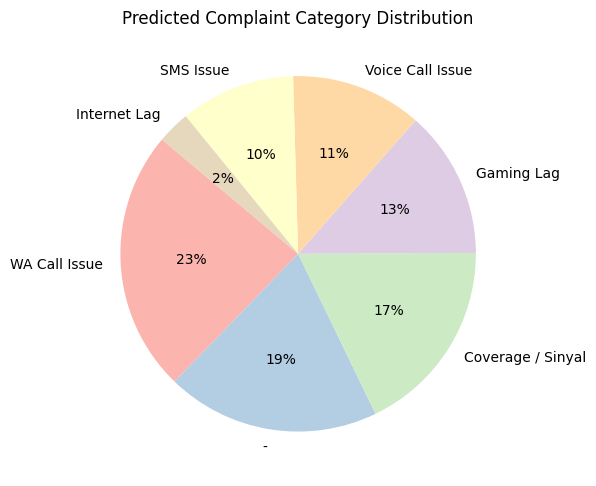

In [81]:
# Pie Chart: Distribution of Predicted Complaint Categories

# Step 1: Count how many times each predicted complaint category appears
# This gives us an idea of which types of complaints are most common in the predictions
category_counts = results_df['pred_category'].value_counts()

# Step 2: Create a pie chart
plt.figure(figsize=(6,6))  # Set figure size for better visibility
plt.pie(
    category_counts,               # Values to plot (number of sites per category)
    labels=category_counts.index,  # Labels for each slice (category names)
    autopct='%d%%',                # Display percentage on each slice
    startangle=140,                # Rotate start of pie chart for better orientation
    colors=plt.cm.Pastel1.colors   # Use pastel colors for a cleaner look
)

# Step 3: Add a title to the chart
plt.title('Predicted Complaint Category Distribution')

# Step 4: Adjust layout to prevent overlapping labels
plt.tight_layout()

# Step 5: Display the chart
plt.show()

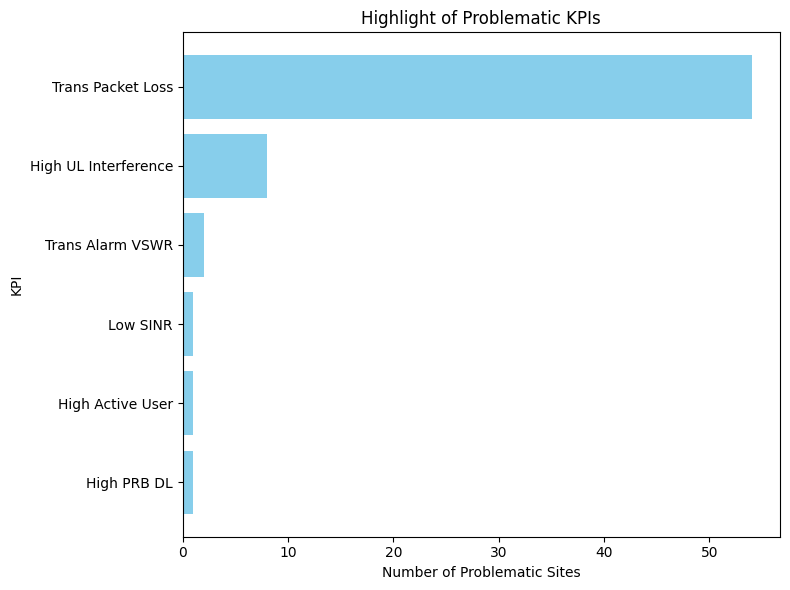

In [82]:
# Bar Chart: Most Frequently Problematic KPIs

# Step 1: Clean KPI names
# Some KPI names in 'sub_root_cause' have additional info in parentheses, like "High Latency (30 ms)"
# We only want the KPI name itself for counting purposes
results_df['kpi_clean'] = results_df['sub_root_cause'].apply(
    lambda x: x.split('(')[0].strip() if pd.notnull(x) else None
)

# Step 2: Count the frequency of each KPI
# This tells us which KPIs appear most often as root causes
kpi_counts = results_df['kpi_clean'].value_counts()

# Step 3: Create a horizontal bar chart
plt.figure(figsize=(8,6))  # Set figure size
plt.barh(kpi_counts.index, kpi_counts.values, color='skyblue')  # Horizontal bars
plt.xlabel('Number of Problematic Sites')  # X-axis label
plt.ylabel('KPI')                           # Y-axis label
plt.title('Highlight of Problematic KPIs')  # Chart title

# Step 4: Invert Y-axis so the most frequent KPI appears at the top
plt.gca().invert_yaxis()

# Step 5: Adjust layout to prevent labels from being cut off
plt.tight_layout()

# Step 6: Display the chart
plt.show()

In [83]:
# Map: Plot Sites Predicted to Have Complaints (Level 1 = 'Yes')

# Step 1: Filter sites where the model predicts a complaint in the next 24 hours
yes_sites = results_df[results_df['pred_24h'] == 'Yes']

# Step 2: Calculate the average latitude and longitude of these sites
# This helps to center the map roughly in the middle of all predicted sites
lat_mean = yes_sites['latitude'].mean()
lon_mean = yes_sites['longitude'].mean()

# Step 3: Initialize a Folium map
# location = [latitude, longitude] sets the center of the map
# zoom_start controls the initial zoom level (higher = closer)
m = folium.Map(location=[lat_mean, lon_mean], zoom_start=5)

# Step 4: Add a CircleMarker for each site
# CircleMarker is better than a simple Marker because size/color can reflect severity
for _, row in yes_sites.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],  # Site coordinates
        radius=7,                                      # Circle radius (bigger = more visible)
        color='red',                                   # Border color of the circle
        fill=True,                                     # Fill the circle
        fill_color='red',                              # Fill color
        fill_opacity=0.8,                              # Transparency of the fill
        popup=f"Site: {row['site_id']}\nCategory: {row['pred_category']}"
        # Popup appears when user clicks the marker
        # Shows Site ID and predicted complaint category
    ).add_to(m)  # Add this CircleMarker to the map

# Step 5: Display the map
# In a Jupyter/Colab notebook, just call the map object
m

# 🗄️ SQLite

- 📝 CSV → SQLite → `.db`  
- 💾 The `.db` file acts like a **prototype company server**, as if the data is connected to a server and updates in real-time  


In [3]:
# 🗄️ Create / connect to SQLite database
conn = sqlite3.connect("vip_server.db")

# 📥 Import CSV files into database tables

# 1️⃣ KPI timeseries data
df1 = pd.read_csv("kpi_timeseries.csv")
df1.to_sql("kpi_timeseries", conn, if_exists="replace", index=False)
# 'if_exists="replace"' will overwrite the table if it already exists

# 2️⃣ Alarms data
df2 = pd.read_csv("alarms.csv")
df2.to_sql("alarms", conn, if_exists="replace", index=False)

# 3️⃣ Tickets / complaints data
df3 = pd.read_csv("tickets.csv")
df3.to_sql("tickets", conn, if_exists="replace", index=False)

# 4️⃣ Network topology data
df4 = pd.read_csv("topology.csv")
df4.to_sql("topology", conn, if_exists="replace", index=False)

# 5️⃣ Events / external factors
df5 = pd.read_csv("events.csv")
df5.to_sql("events", conn, if_exists="replace", index=False)

# 6️⃣ Weather data
df6 = pd.read_csv("weather.csv")
df6.to_sql("weather", conn, if_exists="replace", index=False)

# 🔒 Close the connection
conn.close()  # Always close the database connection when done

# 🚀 Streamlit

- 1️⃣ Run data_processing.py
    - Load data from .db 🗄️
    - Load model .pkl 🤖
    - Make predictions & decode labels 📊
- 2️⃣ Import & call functions in app.py 📌
- 3️⃣ Visualize results in Streamlit 🖥️📈🌍


# 🎉 DONEEEEE